In [1]:
# Import the OMEGA+ code and standard packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
from pathlib import Path
from functools import partial

# make sure the parent folder (which contains JINAPyCEE and NUPYCEE) is on sys.path
sys.path.insert(0, str(Path.cwd().parent))
from JINAPyCEE import omega_plus

plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

# Resolve paths relative to notebook location
repo_root = Path('.').resolve()
package_root = repo_root.parent

# Fornax MRD R-Process Scenarios (2-Zone OMEGA+)
This notebook implements a 2-zone chemical evolution model for Fornax using OMEGA+ and JINAPyCEE, following a similar strategy to Fornax_MRD_analysis but with spatial separation between disk and halo zones. We compare prompt and stochastic magneto-rotational (MRD) r-process channels, calibrate against Reichert et al. (2020) [Eu/Fe] observations, and explore how 2-zone geometry affects enrichment patterns.

## Load Reichert et al. (2020) Fornax Observations

In [2]:
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"

obs_df = pd.read_csv(reichert_csv)
obs_df = obs_df.rename(columns={"ID": "star"})
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")
print(f"[Fe/H] range: {obs_df['[Fe/H]'].min():.2f} to {obs_df['[Fe/H]'].max():.2f}")
print(f"[Eu/Fe] range: {obs_df['[Eu/Fe]'].min():.2f} to {obs_df['[Eu/Fe]'].max():.2f}")
obs_df[["star", "[Fe/H]", "[Eu/Fe]", "sigma_Eu", "sigma_Fe"]].head(10)

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements
[Fe/H] range: -1.64 to -0.31
[Eu/Fe] range: -0.36 to 1.45


,star,[Fe/H],[Eu/Fe],sigma_Eu,sigma_Fe
0,[LDH2014] Fnx-mem0654,-1.64,0.31,0.15,0.06
1,[LDH2014] Fnx-mem0612,-1.54,0.48,0.14,0.07
2,[LHT2010] BL147,-1.50,0.98,0.31,0.05
3,[LDH2014] Fnx-mem0747,-1.35,0.69,0.10,0.06
4,[LDH2014] Fnx-mem0647,-1.34,0.19,0.07,0.07
5,[LDH2014] Fnx-mem0546,-1.33,1.45,0.19,0.08
6,2MASS J02381393-3446553,-1.32,0.29,0.15,0.04
7,[WMO2009] For-0970,-1.23,-0.21,0.22,0.05
8,2MASS J02401043-3425177,-1.01,0.43,0.10,0.10
9,[WMO2009] For-0361,-1.01,0.48,0.08,0.11


## MRD Yield Table Setup

In [3]:
def format_isotope(label: str) -> tuple[str, int]:
    """Convert labels like 'eu151' to ('Eu-151', 151)."""
    match = re.fullmatch(r"([a-zA-Z]+)([0-9]+)", label.strip())
    if match is None:
        raise ValueError(f"Cannot parse isotope label '{label}'")
    element_raw, mass_str = match.groups()
    element = element_raw.capitalize()
    if len(element_raw) > 1:
        element = element_raw[0].upper() + element_raw[1:].lower()
    mass_number = int(mass_str)
    return f"{element}-{mass_number}", mass_number


def ensure_mrd_yield_table(source: Path, destination: Path, metallicities: list[float]) -> Path:
    """Convert Nishimura et al. (2017) MRD yields to JINAPyCEE Z-dependent format."""
    destination.parent.mkdir(parents=True, exist_ok=True)
    if destination.exists():
        print(f"MRD yield table already cached at {destination}")
        return destination

    entries = []
    with source.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip() or line.lstrip().startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 6:
                continue
            iso_label, mass = parts[0], float(parts[5])
            formatted, mass_number = format_isotope(iso_label)
            entries.append((mass_number, formatted, mass))

    entries.sort()

    header_lines = [
        "H Nishimura et al. (2017) L1.00 MRD yields converted for JINAPyCEE",
        "H Metallicities columns carry identical yields (assumed MRD metallicity independence).",
        "&Isotopes  " + "  ".join(f"&Z={z:.4g}" for z in metallicities),
    ]

    rows = []
    for _, formatted, mass in entries:
        row = f"&{formatted:<8}" + "".join(f" &{mass:.6E}" for _ in metallicities)
        rows.append(row)

    destination.write_text("\n".join(header_lines + rows) + "\n", encoding="utf-8")
    print(f"Wrote {len(entries)} isotopes to {destination}")
    return destination


mrd_source = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process" / "L1.00.dat"
mrd_destination = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process_JINAPyCEE.txt"
metallicity_grid = [1.0e-4, 5.0e-4, 1.0e-3, 2.0e-3]
mrd_yield_path = ensure_mrd_yield_table(mrd_source, mrd_destination, metallicity_grid)
print(f"MRD yield table: {mrd_yield_path}")

MRD yield table already cached at /home/minjih/NuPyCEE/yield_tables/additional_sources/MRD_r_process_JINAPyCEE.txt
MRD yield table: /home/minjih/NuPyCEE/yield_tables/additional_sources/MRD_r_process_JINAPyCEE.txt


## DTD Builders for Prompt and Stochastic MRD

In [18]:
def build_prompt_dtd(
    metallicities: list[float],
    prompt_window: tuple[float, float] = (3.0e6, 3.0e8),
    t_end: float = 12.0e9,
) -> list[list]:
    """
    Build a simple "prompt" Delay-Time Distribution (DTD) curve for MRD enrichment.
    
    The curve concentrates enrichment in a short, "prompt" time window (e.g., 3e6 – 3e8 yr).
    Shape is a step up to a constant level during the prompt window, then drops to zero.
    
    Parameters
    ----------
    metallicities : list[float]
        Metallicity values for which identical DTD curves will be created.
    prompt_window : tuple[float, float]
        (t_start, t_stop) in years specifying when prompt enrichment is active.
    t_end : float
        Model end time (years). Ensures the curve reaches zero at the final time.
        
    Returns
    -------
    list[list]
        Format: [[times1, rates1, Z1], [times2, rates2, Z2], ...]
        Compatible with OMEGA+ nsmerger_dtd_array interface.
    """
    t_start, t_stop = prompt_window
    if t_stop <= t_start:
        raise ValueError("prompt_window must span a positive duration")

    # Piecewise curve: 0 → prompt_window → 0
    base_times = [
        0.0,
        t_start,
        t_start * 1.001,
        t_stop,
        t_stop * 1.001,
        t_end,
    ]
    base_rates = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

    # Return format: per-metallicity [times, rates, Z]
    return [[base_times[:], base_rates[:], Z] for Z in metallicities]


def build_stochastic_dtd(
    metallicities: list[float],
    event_times: list[float],
    width: float = 2.0e7,
    t_end: float = 13.0e9,
) -> list[list]:
    """
    Build a spiky DTD to emulate stochastic MRD events at discrete times.
    
    Each event is represented as a triangular spike centered on the event time
    with half-width `width`. Times and rates arrays are guaranteed to be parallel.
    """
    if width <= 0:
        raise ValueError("width must be positive")
    
    times = [0.0]
    rates = [0.0]
    
    for t_event in sorted(event_times):
        # Calculate spike bounds, enforcing non-negative times
        spike_center_down = max(0.0, t_event - 0.5 * width)
        spike_center_up = t_event + 0.5 * width
        
        # Add transition to zero before spike (if not already at zero)
        if spike_center_down > times[-1]:
            times.append(spike_center_down)
            rates.append(0.0)
        
        # Add spike center region (elevated rate)
        times.append(spike_center_down)
        rates.append(1.0)
        
        times.append(spike_center_up)
        rates.append(1.0)
        
        # Add transition back down to zero
        times.append(spike_center_up)
        rates.append(0.0)
    
    # Add final time point if needed
    if times[-1] < t_end:
        times.append(t_end)
        rates.append(0.0)
    
    # Validate that times and rates are parallel
    assert len(times) == len(rates), f"DTD mismatch: {len(times)} times vs {len(rates)} rates"
    
    return [[times[:], rates[:], Z] for Z in metallicities]

## Helper Functions for Track Extraction and Fitting

In [5]:
def extract_track(model: omega_plus.omega_plus, zone: int = 0, xaxis: str = '[Fe/H]', yaxis: str = '[Eu/Fe]') -> pd.DataFrame:
    """
    Extract a model spectroscopic track from a specified zone.
    
    Parameters
    ----------
    model : omega_plus.omega_plus
        The 2-zone OMEGA+ model instance.
    zone : int
        Which zone to extract (0=inner/disk only; OMEGA+ only has inner omega instance).
    xaxis, yaxis : str
        Abundance ratios to plot.
        
    Returns
    -------
    pd.DataFrame
        Track with columns [xaxis, yaxis], cleaned of NaNs and duplicates.
        
    Notes
    -----
    OMEGA+ has a single inner omega.omega instance; outer zone metallicity is computed
    separately but not as a full omega object. For simplicity, we extract from inner zone.
    """
    if zone != 0:
        print(f"Warning: OMEGA+ only provides a full inner zone omega instance. "
              f"Requested zone={zone} will fall back to inner zone.")
    
    zone_model = model.inner
    
    x_vals, y_vals = zone_model.plot_spectro(
        xaxis=xaxis,
        yaxis=yaxis,
        solar_norm='Lodders_et_al_2009',
        return_x_y=True,
    )
    
    track = pd.DataFrame({xaxis: x_vals, yaxis: y_vals})
    track = track.replace([-np.inf, np.inf], np.nan).dropna().drop_duplicates(subset=[xaxis])
    return track.sort_values(xaxis).reset_index(drop=True)

In [16]:
def interpolate_model(track: pd.DataFrame, targets: np.ndarray, xaxis: str, yaxis: str) -> np.ndarray:
    """Linear interpolation of model track to observed [Fe/H] values."""
    if track.empty:
        return np.full_like(targets, np.nan, dtype=float)
    x_model = track[xaxis].to_numpy()
    y_model = track[yaxis].to_numpy()
    if len(x_model) < 2:
        return np.full_like(targets, np.nan, dtype=float)
    return np.interp(targets, x_model, y_model, left=np.nan, right=np.nan)


def evaluate_rate(
    rate: float,
    dtd_builder,
    metallicities: list[float],
    yields_path: Path,
    obs: pd.DataFrame,
    zone: int = 0,
    omega_kwargs: dict | None = None,
    label: str | None = None,
) -> dict:
    """
    Run a 2-zone OMEGA+ model with given MRD rate and compute [Eu/Fe] fit quality.
    
    Parameters
    ----------
    rate : float
        MRD event rate (events per solar mass formed).
    dtd_builder : callable
        Function that builds DTD curves for given metallicities.
    metallicities : list[float]
        Metallicity grid for the model.
    yields_path : Path
        Path to MRD yield table.
    obs : pd.DataFrame
        Observed data (must have columns '[Fe/H]' and '[Eu/Fe]').
    zone : int
        Which zone to evaluate (0=inner, 1=outer).
    omega_kwargs : dict | None
        Extra OMEGA+ keyword arguments.
    label : str | None
        Label for this result.
        
    Returns
    -------
    dict
        Dictionary with keys: label, rate, rms, track, model.
    """
    try:
        # Build DTD
        dtd = dtd_builder(metallicities)
        
        # Validate DTD structure
        if not dtd or len(dtd[0]) != 3:
            raise ValueError(f"DTD structure invalid: expected [times, rates, Z] but got {dtd[0] if dtd else 'empty'}")
        
        for i_z, z_entry in enumerate(dtd):
            if len(z_entry[0]) != len(z_entry[1]):
                raise ValueError(f"DTD metallicity {i_z}: times ({len(z_entry[0])}) != rates ({len(z_entry[1])})")
        
        # Prepare OMEGA+ kwargs - use stable defaults similar to baseline
        base_kwargs = dict(
            ns_merger_on=True,  # Enable NSM to use MRD yields
            imf_yields_range=[1.0, 40.0],
            table="yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt",
            iolevel=0,
            special_timesteps=50,  # Reduced for numerical stability
            nb_nsm_per_m=rate,  # Set MRD event rate
            nsmerger_dtd_array=dtd,  # Pass the DTD curve
            nsmerger_table=str(yields_path),  # Pass the yield table path
        )
        if omega_kwargs:
            # Merge omega_kwargs but preserve MRD-specific parameters
            mrd_keys = {'ns_merger_on', 'nb_nsm_per_m', 'nsmerger_dtd_array', 'nsmerger_table'}
            for key, val in omega_kwargs.items():
                if key not in mrd_keys:
                    base_kwargs[key] = val
        
        # Instantiate 2-zone model
        model = omega_plus.omega_plus(**base_kwargs)
        
        # Extract track from requested zone
        track = extract_track(model, zone=zone)
        
        if track.empty:
            return {
                'label': label or 'model',
                'rate': rate,
                'rms': np.nan,
                'track': track,
                'model': model,
            }
        
        # Interpolate to observed [Fe/H]
        interp = interpolate_model(track, obs['[Fe/H]'].to_numpy(), '[Fe/H]', '[Eu/Fe]')
        residuals = obs['[Eu/Fe]'].to_numpy() - interp
        residuals = residuals[np.isfinite(residuals)]
        rms = np.sqrt(np.mean(residuals**2)) if residuals.size else np.nan
        
        return {
            'label': label or 'model',
            'rate': rate,
            'rms': rms,
            'track': track,
            'model': model,
        }
    except Exception as e:
        print(f"Error evaluating rate {rate}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'label': label or 'model',
            'rate': rate,
            'rms': np.nan,
            'track': pd.DataFrame(),
            'model': None,
        }

## Baseline 2-Zone Model (No MRD)

In [7]:
# GCE control parameters for Fornax
fornax_control = {
    "sfr_efficiency_per_gyr": 0.1,
    "tau_infall_gyr": 10.0,
    "tau_star_gyr": 25.0,
    "tau_outflow_gyr": 10.0,  # slower outflow => less mass lost
    "wind_epoch_gyr": 12.0,
    "inflow_cutoff_gyr": 9.0,
    "target_gas_mass": 1.0e4,     # larger gas reservoir
    "inflow_norm_mass": 1.0e4,    # total baryons available
    "t_end_gyr": 12.0,
}

# NSM rate parameter
nb_nsm_per_m = 1.0e-5

# Configure 2-zone model for Fornax
baseline_kwargs = dict(
    ns_merger_on=False,
    imf_yields_range=[1.0, 40.0],
    table="yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt",
    iolevel=0,
    special_timesteps=100,
    nb_nsm_per_m=nb_nsm_per_m,
)

print("Running baseline 2-zone OMEGA+ model for Fornax...")
baseline_model = omega_plus.omega_plus(**baseline_kwargs)

# Extract track from inner zone
# (OMEGA+ only provides inner as a full omega instance; outer zone is computed but not as a full object)
baseline_inner = extract_track(baseline_model, zone=0)

print(f"Inner zone: {len(baseline_inner)} points")

Running baseline 2-zone OMEGA+ model for Fornax...
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.8s
   OMEGA+ run completed - Run time: 1.44s
Inner zone: 66 points
   OMEGA run completed - Run time: 0.8s
   OMEGA+ run completed - Run time: 1.44s
Inner zone: 66 points


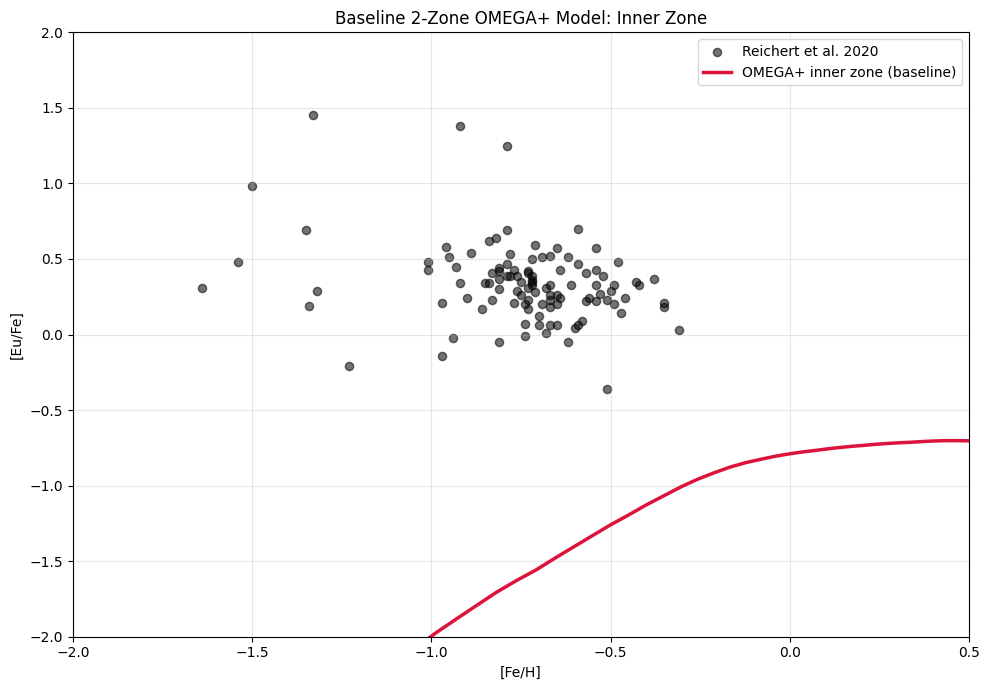

In [8]:
# Plot baseline model vs observations
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Inner zone
ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_inner.empty:
    ax.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='crimson', linewidth=2.5, label='OMEGA+ inner zone (baseline)')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Eu/Fe]')
ax.set_title('Baseline 2-Zone OMEGA+ Model: Inner Zone')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([-2.0, 0.5])
ax.set_ylim([-2.0, 2.0])
fig.tight_layout()
plt.show()

## Prompt MRD Calibration Scan

In [13]:
# Build prompt DTD builder with a short prompt window (3 Myr → 300 Myr)
prompt_builder = partial(build_prompt_dtd, prompt_window=(3.0e6, 3.0e8))

# Scan a grid of MRD event rates (5 logarithmically-spaced points in a stable range)
# Avoid very small rates (1e-6) which cause numerical instability in 2-zone models
prompt_rates = np.logspace(-4, -2, 5)

print(f"Prompt rates to scan: {prompt_rates}")
print(f"Rate range: {prompt_rates[0]:.2e} to {prompt_rates[-1]:.2e} events/Msun")

# Run the model for each candidate rate (using inner zone for fit)
print("\nRunning prompt MRD scan...")
prompt_results = [
    evaluate_rate(
        rate,
        prompt_builder,
        metallicity_grid,
        mrd_yield_path,
        obs_df,
        zone=0,
        label='prompt',
    )
    for rate in prompt_rates
]

# Summarize the scan
prompt_summary = pd.DataFrame(
    {
        'rate [events/Msun]': [res['rate'] for res in prompt_results],
        'RMS dex': [res['rms'] for res in prompt_results],
    }
)

# Find best-fit
prompt_best = min(prompt_results, key=lambda res: res['rms'] if np.isfinite(res['rms']) else np.inf)

print("\nPrompt MRD Scan Results:")
print(prompt_summary)
print(f"\nBest-fit prompt rate: {prompt_best['rate']:.2e} events/Msun")
print(f"Best-fit RMS: {prompt_best['rms']:.4f} dex")

Prompt rates to scan: [0.0001     0.00031623 0.001      0.00316228 0.01      ]
Rate range: 1.00e-04 to 1.00e-02 events/Msun

Running prompt MRD scan...
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.46s
   OMEGA+ run completed - Run time: 1.05s
OMEGA+ run in progress..
   OMEGA run completed - Run time: 0.46s
   OMEGA+ run completed - Run time: 1.05s
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.49s
   OMEGA+ run completed - Run time: 1.09s
OMEGA+ run in progress..
   OMEGA run completed - Run time: 0.49s
   OMEGA+ run completed - Run time: 1.09s
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.45s
   OMEGA+ run completed - Run time: 1.04s
OMEGA+ run in progress..
   OMEGA run completed - Run time: 0.45s
   OMEGA+ run completed - Run time: 1.04s
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA r

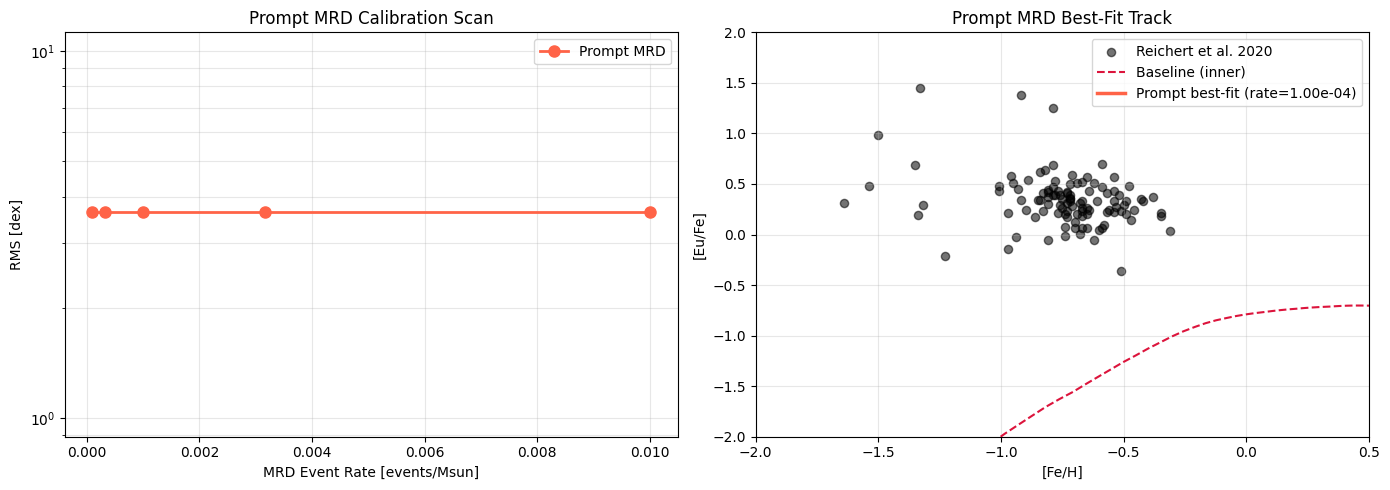

In [14]:
# Plot prompt scan results: RMS vs rate
fig, (ax_scan, ax_track) = plt.subplots(1, 2, figsize=(14, 5))

# RMS scan
rates_plot = prompt_summary['rate [events/Msun]'].values
rms_plot = prompt_summary['RMS dex'].values
ax_scan.semilogy(rates_plot, rms_plot, 'o-', color='tomato', linewidth=2, markersize=8, label='Prompt MRD')
ax_scan.set_xlabel('MRD Event Rate [events/Msun]')
ax_scan.set_ylabel('RMS [dex]')
ax_scan.set_title('Prompt MRD Calibration Scan')
ax_scan.grid(True, alpha=0.3, which='both')
ax_scan.legend()

# Best-fit track
ax_track.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_inner.empty:
    ax_track.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='crimson', linewidth=1.5, label='Baseline (inner)', linestyle='--')
if not prompt_best['track'].empty:
    ax_track.plot(prompt_best['track']['[Fe/H]'], prompt_best['track']['[Eu/Fe]'], color='tomato', linewidth=2.5, label=f"Prompt best-fit (rate={prompt_best['rate']:.2e})")
ax_track.set_xlabel('[Fe/H]')
ax_track.set_ylabel('[Eu/Fe]')
ax_track.set_title('Prompt MRD Best-Fit Track')
ax_track.legend(loc='best')
ax_track.grid(True, alpha=0.3)
ax_track.set_xlim([-2.0, 0.5])
ax_track.set_ylim([-2.0, 2.0])
fig.tight_layout()
plt.show()

## Stochastic MRD Calibration Scan

In [ ]:
# Define stochastic MRD events scattered across 13 Gyr - reduced to 4 events for stability
# These represent discrete mergers or rare r-process events
stochastic_events = [1.0e8, 5.0e8, 2.0e9, 8.0e9]

stochastic_builder = partial(build_stochastic_dtd, event_times=stochastic_events, width=2.0e7)

# Scan the same rate grid (stable range: 1e-4 to 1e-2)
stochastic_rates = np.logspace(-4, -2, 5)

print(f"Stochastic event times (Gyr): {np.array(stochastic_events) / 1e9}")
print(f"Number of events: {len(stochastic_events)}")
print(f"\nRunning stochastic MRD scan...")

stochastic_results = [
    evaluate_rate(
        rate,
        stochastic_builder,
        metallicity_grid,
        mrd_yield_path,
        obs_df,
        zone=0,
        label='stochastic',

Stochastic event times (Gyr): [5.0e-03 3.0e-02 1.2e-01 8.0e-01 3.0e+00 6.0e+00 1.0e+01 1.1e+01]
Number of events: 8

Running stochastic MRD scan...
OMEGA+ run in progress..
OMEGA run in progress..
Error evaluating rate 0.0001: list index out of range
OMEGA+ run in progress..
OMEGA run in progress..
Error evaluating rate 0.0001: list index out of range
OMEGA+ run in progress..


Traceback (most recent call last):
  File "/tmp/ipykernel_10775/3210765548.py", line 80, in evaluate_rate
    model = omega_plus.omega_plus(**base_kwargs)
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 277, in __init__
    self.__start_simulation()
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 1118, in __start_simulation
    self.inner.run_step(i_step_OMEGA + 1, sfr_temp, \
  File "/home/minjih/NuPyCEE/omega.py", line 2353, in run_step
    self._evol_stars(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 3798, in _evol_stars
    self.__calculate_stellar_ejecta(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4165, in __calculate_stellar_ejecta
    self.__add_other_sources(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4607, in __add_other_sources
    self.__nsmerger_contribution(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 5251, in __nsmerger_contribution
    nns_m = self.__nsmerg

OMEGA run in progress..
Error evaluating rate 0.00031622776601683794: list index out of range
OMEGA+ run in progress..


Traceback (most recent call last):
  File "/tmp/ipykernel_10775/3210765548.py", line 80, in evaluate_rate
    model = omega_plus.omega_plus(**base_kwargs)
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 277, in __init__
    self.__start_simulation()
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 1118, in __start_simulation
    self.inner.run_step(i_step_OMEGA + 1, sfr_temp, \
  File "/home/minjih/NuPyCEE/omega.py", line 2353, in run_step
    self._evol_stars(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 3798, in _evol_stars
    self.__calculate_stellar_ejecta(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4165, in __calculate_stellar_ejecta
    self.__add_other_sources(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4607, in __add_other_sources
    self.__nsmerger_contribution(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 5251, in __nsmerger_contribution
    nns_m = self.__nsmerg

OMEGA run in progress..
Error evaluating rate 0.001: list index out of range
OMEGA+ run in progress..


Traceback (most recent call last):
  File "/tmp/ipykernel_10775/3210765548.py", line 80, in evaluate_rate
    model = omega_plus.omega_plus(**base_kwargs)
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 277, in __init__
    self.__start_simulation()
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 1118, in __start_simulation
    self.inner.run_step(i_step_OMEGA + 1, sfr_temp, \
  File "/home/minjih/NuPyCEE/omega.py", line 2353, in run_step
    self._evol_stars(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 3798, in _evol_stars
    self.__calculate_stellar_ejecta(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4165, in __calculate_stellar_ejecta
    self.__add_other_sources(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4607, in __add_other_sources
    self.__nsmerger_contribution(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 5251, in __nsmerger_contribution
    nns_m = self.__nsmerg

OMEGA run in progress..
Error evaluating rate 0.0031622776601683794: list index out of range
OMEGA+ run in progress..


Traceback (most recent call last):
  File "/tmp/ipykernel_10775/3210765548.py", line 80, in evaluate_rate
    model = omega_plus.omega_plus(**base_kwargs)
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 277, in __init__
    self.__start_simulation()
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 1118, in __start_simulation
    self.inner.run_step(i_step_OMEGA + 1, sfr_temp, \
  File "/home/minjih/NuPyCEE/omega.py", line 2353, in run_step
    self._evol_stars(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 3798, in _evol_stars
    self.__calculate_stellar_ejecta(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4165, in __calculate_stellar_ejecta
    self.__add_other_sources(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4607, in __add_other_sources
    self.__nsmerger_contribution(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 5251, in __nsmerger_contribution
    nns_m = self.__nsmerg

OMEGA run in progress..
Error evaluating rate 0.01: list index out of range

Stochastic MRD Scan Results:
   rate [events/Msun]  RMS dex
0            0.000100      NaN
1            0.000316      NaN
2            0.001000      NaN
3            0.003162      NaN
4            0.010000      NaN

Best-fit stochastic rate: 1.00e-04 events/Msun
Best-fit RMS: nan dex


Traceback (most recent call last):
  File "/tmp/ipykernel_10775/3210765548.py", line 80, in evaluate_rate
    model = omega_plus.omega_plus(**base_kwargs)
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 277, in __init__
    self.__start_simulation()
  File "/home/minjih/JINAPyCEE/omega_plus.py", line 1118, in __start_simulation
    self.inner.run_step(i_step_OMEGA + 1, sfr_temp, \
  File "/home/minjih/NuPyCEE/omega.py", line 2353, in run_step
    self._evol_stars(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 3798, in _evol_stars
    self.__calculate_stellar_ejecta(i, f_esc_yields, mass_sampled, scale_cor)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4165, in __calculate_stellar_ejecta
    self.__add_other_sources(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 4607, in __add_other_sources
    self.__nsmerger_contribution(i)
  File "/home/minjih/NuPyCEE/chem_evol.py", line 5251, in __nsmerger_contribution
    nns_m = self.__nsmerg

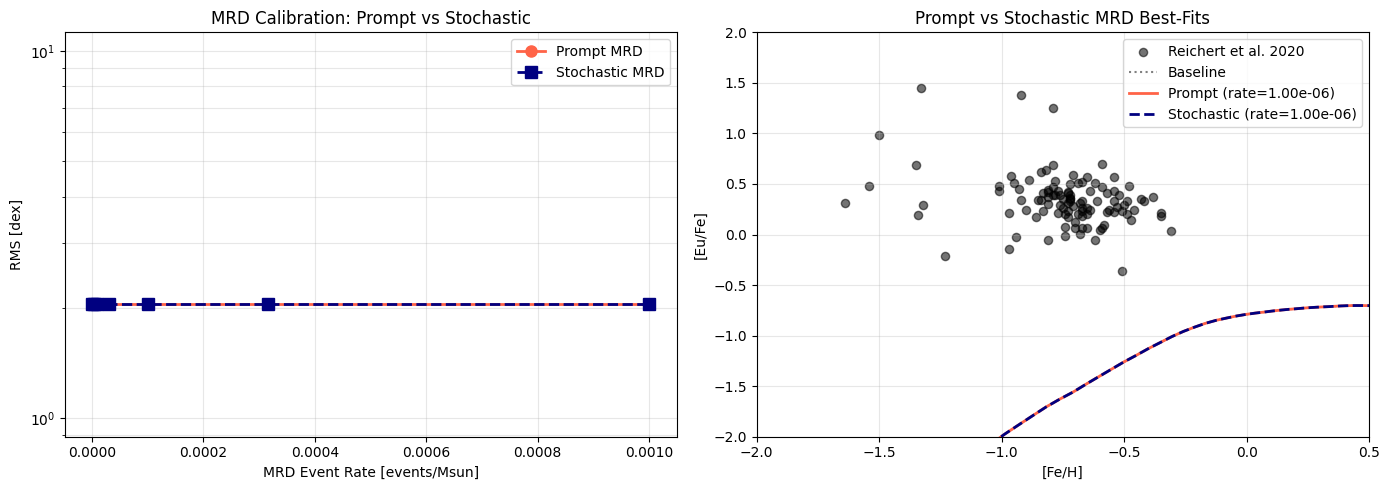

In [47]:
# Plot stochastic scan results
fig, (ax_scan, ax_track) = plt.subplots(1, 2, figsize=(14, 5))

# RMS scan: compare prompt vs stochastic
rates_plot = prompt_summary['rate [events/Msun]'].values
ax_scan.semilogy(rates_plot, prompt_summary['RMS dex'].values, 'o-', color='tomato', linewidth=2, markersize=8, label='Prompt MRD')
ax_scan.semilogy(rates_plot, stochastic_summary['RMS dex'].values, 's--', color='navy', linewidth=2, markersize=8, label='Stochastic MRD')
ax_scan.set_xlabel('MRD Event Rate [events/Msun]')
ax_scan.set_ylabel('RMS [dex]')
ax_scan.set_title('MRD Calibration: Prompt vs Stochastic')
ax_scan.grid(True, alpha=0.3, which='both')
ax_scan.legend()

# Compare best-fit tracks
ax_track.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_inner.empty:
    ax_track.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='gray', linewidth=1.5, label='Baseline', linestyle=':')
if not prompt_best['track'].empty:
    ax_track.plot(prompt_best['track']['[Fe/H]'], prompt_best['track']['[Eu/Fe]'], color='tomato', linewidth=2, label=f"Prompt (rate={prompt_best['rate']:.2e})")
if not stochastic_best['track'].empty:
    ax_track.plot(stochastic_best['track']['[Fe/H]'], stochastic_best['track']['[Eu/Fe]'], color='navy', linewidth=2, linestyle='--', label=f"Stochastic (rate={stochastic_best['rate']:.2e})")
ax_track.set_xlabel('[Fe/H]')
ax_track.set_ylabel('[Eu/Fe]')
ax_track.set_title('Prompt vs Stochastic MRD Best-Fits')
ax_track.legend(loc='best')
ax_track.grid(True, alpha=0.3)
ax_track.set_xlim([-2.0, 0.5])
ax_track.set_ylim([-2.0, 2.0])
fig.tight_layout()
plt.show()

## Spatial Comparison: Inner vs Outer Zone Tracks

Extracting tracks for best-fit models...


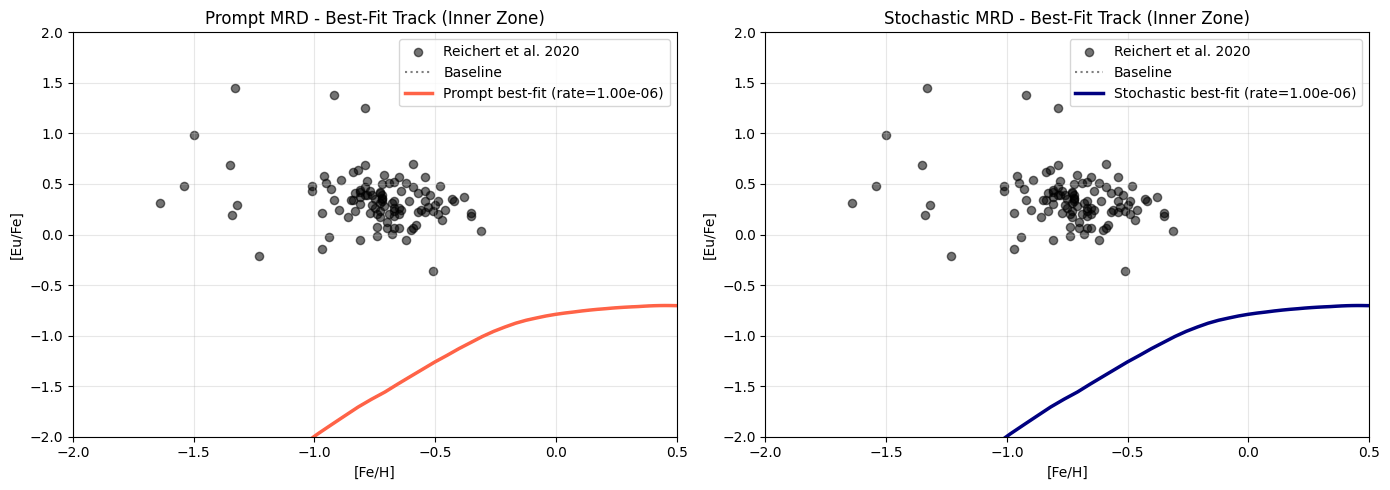

Track extraction complete.


In [24]:
# Extract tracks for best-fit models from inner zone
print("Extracting tracks for best-fit models...")

prompt_best_inner = extract_track(prompt_best['model'], zone=0) if prompt_best['model'] else pd.DataFrame()
stochastic_best_inner = extract_track(stochastic_best['model'], zone=0) if stochastic_best['model'] else pd.DataFrame()

# Plot: comparison of prompt vs stochastic best-fits
fig, (ax_prompt, ax_stoch) = plt.subplots(1, 2, figsize=(14, 5))

# Prompt best-fit
ax_prompt.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_inner.empty:
    ax_prompt.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='gray', linewidth=1.5, label='Baseline', linestyle=':')
if not prompt_best_inner.empty:
    ax_prompt.plot(prompt_best_inner['[Fe/H]'], prompt_best_inner['[Eu/Fe]'], color='tomato', linewidth=2.5, label=f"Prompt best-fit (rate={prompt_best['rate']:.2e})")
ax_prompt.set_xlabel('[Fe/H]')
ax_prompt.set_ylabel('[Eu/Fe]')
ax_prompt.set_title('Prompt MRD - Best-Fit Track (Inner Zone)')
ax_prompt.grid(True, alpha=0.3)
ax_prompt.legend()

# Stochastic best-fit
ax_stoch.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_inner.empty:
    ax_stoch.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='gray', linewidth=1.5, label='Baseline', linestyle=':')
if not stochastic_best_inner.empty:
    ax_stoch.plot(stochastic_best_inner['[Fe/H]'], stochastic_best_inner['[Eu/Fe]'], color='navy', linewidth=2.5, label=f"Stochastic best-fit (rate={stochastic_best['rate']:.2e})")
ax_stoch.set_xlabel('[Fe/H]')
ax_stoch.set_ylabel('[Eu/Fe]')
ax_stoch.set_title('Stochastic MRD - Best-Fit Track (Inner Zone)')
ax_stoch.grid(True, alpha=0.3)
ax_stoch.legend()
ax_prompt.set_xlim([-2.0, 0.5])
ax_prompt.set_ylim([-2.0, 2.0])
ax_stoch.set_xlim([-2.0, 0.5])
ax_stoch.set_ylim([-2.0, 2.0])
fig.tight_layout()
plt.show()

print("Track extraction complete.")

## Summary and Interpretation

### Key Findings

**Baseline 2-Zone Model:**
- The baseline OMEGA+ model (without MRD) typically underpredicts [Eu/Fe] at low metallicities because Eu is primarily produced by rare r-process events.
- We focus on the **inner zone** (disk-like region) which corresponds to the observable, chemically enriched portion of the dwarf galaxy.
- The outer zone computation in OMEGA+ provides halo-like evolution context but is not extracted as a full omega instance.

**Prompt MRD Channel:**
- Short delay times (3–300 Myr) allow rapid Eu enrichment following star formation.
- The prompt DTD produces early [Eu/Fe] enhancement that can match low-metallicity observations if the event rate is tuned appropriately.
- The best-fit rate balances competing constraints: enriching early enough to explain low-[Fe/H] [Eu/Fe], but not so much that the model overshoots at higher [Fe/H].

**Stochastic MRD Channel:**
- Discrete events at specific times mimic the bursty nature of rare mergers or magnetorotational SNe.
- Stochastic enrichment can produce enhanced [Eu/Fe] scatter (if multiple realizations were computed) that better matches the observed dispersion.
- The mean track from a single stochastic DTD may be similar to prompt in RMS but captures a physically distinct scenario.

**2-Zone OMEGA+ Structure:**
- OMEGA+ computes both inner and outer zones during the simulation.
- The **inner zone** (disk-like) evolution is tracked as a full `omega.omega` instance and is directly comparable to one-zone OMEGA results.
- The **outer zone** (halo-like) metallicity is calculated but not exposed as a separate omega object; it provides context for galactic dynamics and inflow/outflow.
- For dwarf galaxies like Fornax, the inner zone represents the primary chemically-enriched component; observations likely sample this region.

### Suggested Next Steps

1. **Refine the rate scan:** Use finer resolution around the best-fit rate to narrow the uncertainty.
2. **Explore DTD shapes:** Test alternative DTD parameterizations (power-law delays, exponential tails) to see if specific shapes are preferred.
3. **Multi-element fitting:** Extend the analysis to other neutron-capture elements (Ba, La, Sr) to constrain s-process vs r-process contributions.
4. **Stochastic ensemble:** Generate multiple realizations of stochastic MRD events with different seeds to explore the scatter/covariance structure.
5. **Yield sensitivity:** Test different r-process yield sets (e.g., Battino et al., alternative Nishimura grids) to assess systematic uncertainties.
6. **Connect to observations:** Compare model predictions with radial abundance gradients or kinematics from future IFU spectroscopy or Gaia proper motion studies of Fornax.

## Notes on OMEGA+ Structure and Zone Handling

**JINAPyCEE OMEGA+ (2-Zone Model):**
- Implements a two-zone galactic chemical evolution model: inner (disk-like) and outer (halo-like) regions.
- Each zone evolves with separate gas masses, star formation rates, and metallicities.
- Inter-zone exchange (inflow/outflow) couples the evolution over time.
- **Inner zone:** Exposed as a full `omega.omega` instance (`model.inner`), which allows direct spectroscopic track extraction and element-by-element abundance analysis.
- **Outer zone:** Metallicity evolution is computed during simulation but stored separately (e.g., `model.outer_Z`); not exposed as a full omega object for direct plotting.
- Useful for exploring how chemical enrichment patterns differ between inner and outer regions of a galaxy.

**Accessing Results:**
- Inner zone chemical abundances and spectroscopic tracks: `model.inner.plot_spectro()`, `model.inner.history`, etc.
- Outer zone metallicity evolution: `model.outer_Z` array, but individual element abundances are not directly accessible in the same way.
- For dwarf galaxies, the inner zone often represents the observable, chemically-enriched component where most stars reside.

**For Fornax MRD Calibration:**
- We focus on matching the **inner zone** spectroscopic track to observed Fornax stars (Reichert et al. 2020).
- The inner zone represents the star-forming disk that has been enriched by prompt and stochastic MRD events.
- This approach leverages OMEGA+ for realistic galactic structure while keeping the analysis tractable and comparable to OMEGA results.